In [13]:
#importing modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization,Dropout
import numpy as np
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50

In [2]:
#loading dataset 
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    image_size=(256,256),
    batch_size=32
)

Found 2702 files belonging to 2 classes.


In [3]:
class_names=dataset.class_names
class_names

['Negative', 'Positive']

In [4]:
#finding how many total batches of images are there
len(dataset)

85

In [5]:
#A function to split the dataset into training,validation and testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
#Splitting the dataset into training, validation and testing
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [7]:
#Shuffling and PreFetching the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
#Resizing and Rescaling the Images
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255),
])

In [22]:
ResNet_50 = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze pretrained layers
for layer in ResNet_50.layers:
    layer.trainable = False

model = Sequential()
model.add(ResNet_50)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [23]:
#Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
#Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    callbacks=[early_stopping])

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 65s 912ms/step - accuracy: 0.7774 - loss: 8.8123 - val_accuracy: 0.9297 - val_loss: 0.2057
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 63s 930ms/step - accuracy: 0.9359 - loss: 0.1584 - val_accuracy: 0.9141 - val_loss: 0.2171
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 948ms/step - accuracy: 0.9254 - loss: 0.1519 - val_accuracy: 0.9219 - val_loss: 0.1495
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 65s 964ms/step - accuracy: 0.9366 - loss: 0.0969 - val_accuracy: 0.9375 - val_loss: 0.1482
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9579 - loss: 0.0973 - val_accuracy: 0.9375 - val_loss: 0.2357
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9371 - loss: 0.1459 - val_accuracy: 0.9609 - val_loss: 0.1298
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9648 - loss: 0.0838 - val_accuracy: 0.9766 - val_loss: 0.1216
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9866 - loss: 0.0446 - val_accuracy: 0.9727

In [26]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 755ms/step - accuracy: 0.9629 - loss: 0.0838


[0.09664255380630493, 0.9756944179534912]

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

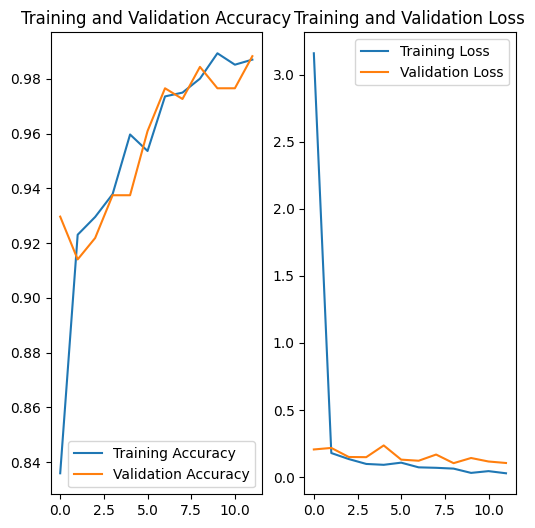

In [29]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(12), acc, label='Training Accuracy')
plt.plot(range(12), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(12), loss, label='Training Loss')
plt.plot(range(12), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


2026-02-08 22:42:09.611233: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


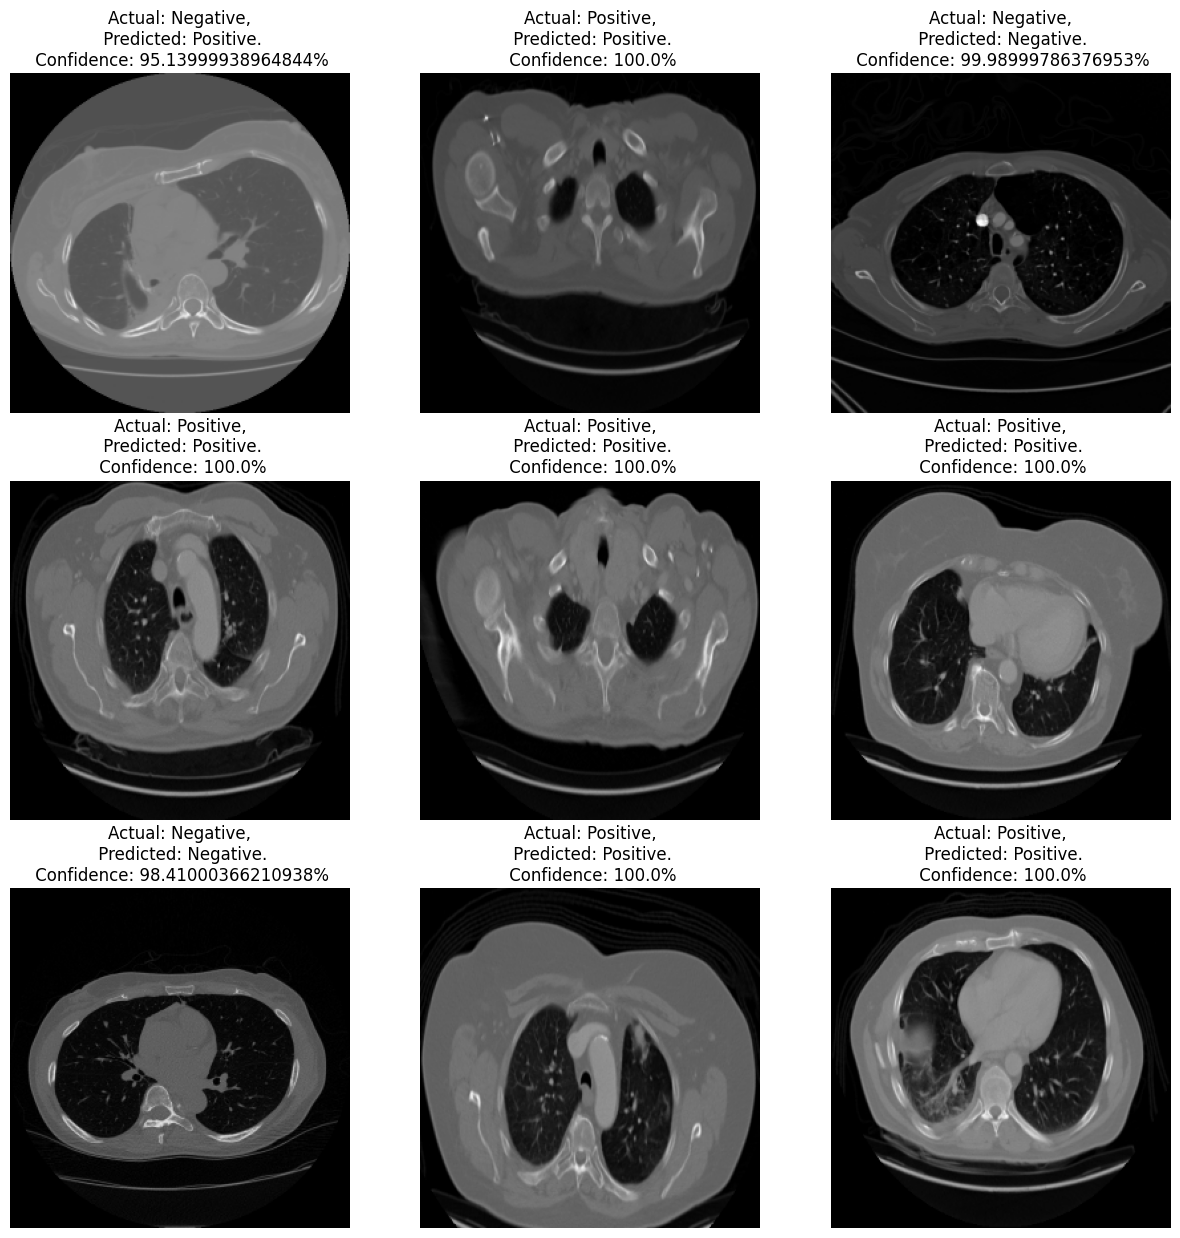

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

2026-02-08 22:42:33.933642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_test shape: (288, 256, 256, 3)
y_true shape: (288,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 754ms/step


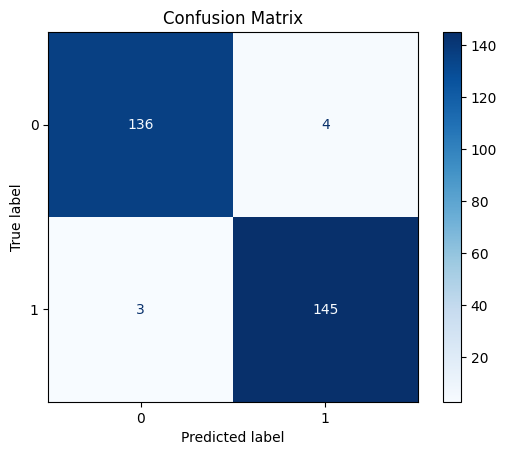


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       140
           1       0.97      0.98      0.98       148

    accuracy                           0.98       288
   macro avg       0.98      0.98      0.98       288
weighted avg       0.98      0.98      0.98       288



In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


#Convert test_ds → NumPy arrays

X_test = []
y_true = []

for images, labels in test_ds:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

print("X_test shape:", X_test.shape)
print("y_true shape:", y_true.shape)


# Predict using your trained model

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Confusion Matrix

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


#Classification Report

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

In [33]:
model.save("saved_models/resnet1.h5")

## Failure Analysis

In [34]:
#creating seperate folder
import os

base_dir = "Failure_Analysis"
img_dir = os.path.join(base_dir, "failure_images")

os.makedirs(img_dir, exist_ok=True)

In [35]:
import pandas as pd
import cv2

BASE_DIR = "failure_dataset"
IMG_DIR = os.path.join(BASE_DIR, "images")
os.makedirs(IMG_DIR, exist_ok=True)

# Step 1: Helper proxy functions


def estimate_image_quality(img):
    img_uint8 = img.astype(np.uint8)
    variance = cv2.Laplacian(img_uint8, cv2.CV_64F).var()
    if variance < 50:
        return "Low"
    elif variance < 150:
        return "Medium"
    else:
        return "High"

def estimate_mri_contrast(img):
    contrast = img.max() - img.min()
    if contrast < 40:
        return "Low"
    elif contrast < 120:
        return "Medium"
    else:
        return "High"


# Step 2: Initialize variables

records = []
case_counter = 1


# Step 3: Loop through test dataset

for images, labels in test_ds:

    preds = model.predict(images, verbose=0)

    for i in range(images.shape[0]):
        img = images[i].numpy()
        label_val = labels[i].numpy()

        # ----- True label -----
        if label_val.ndim > 0:
            y_true = int(np.argmax(label_val))
        else:
            y_true = int(label_val)

        # ----- Prediction handling -----
        if preds.shape[1] == 1:  # sigmoid
            prob = float(preds[i][0])
            y_pred = int(prob >= 0.5)
        else:  # softmax
            prob = float(np.max(preds[i]))
            y_pred = int(np.argmax(preds[i]))

        # ----- Only failure cases -----
        if y_true != y_pred:
            failure_type = "FN" if y_true == 1 else "FP"

            # ----- Normalize image -----
            if img.max() <= 1.0:
                img_to_save = (img * 255).clip(0, 255).astype(np.uint8)
            else:
                img_to_save = img.astype(np.uint8)

            # ----- Handle grayscale / RGB -----
            if img_to_save.ndim == 2:
                save_img = img_to_save
            elif img_to_save.shape[-1] == 1:
                save_img = img_to_save[:, :, 0]
            else:
                save_img = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)

            # ----- Save image -----
            case_id = f"{case_counter:03d}"
            image_name = f"{case_id}.png"
            image_path = os.path.join(IMG_DIR, image_name)
            cv2.imwrite(image_path, save_img)

            # ----- Proxy metrics -----
            image_quality = estimate_image_quality(save_img)
            mri_contrast = estimate_mri_contrast(save_img)

            # ----- Record entry -----
            records.append({
                "case_id": case_id,
                "failure_type": failure_type,   # FP or FN
                "true_label": y_true,           # 0 = non-cancer, 1 = cancer
                "predicted_label": y_pred,
                "prediction_probability": round(prob, 4),
                "image_quality": image_quality,
                "mri_contrast": mri_contrast,
                "image_path": image_path
            })

            case_counter += 1


# Step 4: Save Excel file

failure_df = pd.DataFrame(records)
failure_df.to_excel(os.path.join(BASE_DIR, "failure_cases.xlsx"), index=False)

failure_df


,case_id,failure_type,true_label,predicted_label,prediction_probability,image_quality,mri_contrast,image_path
0,001,FP,0,1,0.9514,High,High,failure_dataset/images/001.png
1,002,FP,0,1,0.6914,High,High,failure_dataset/images/002.png
2,003,FP,0,1,0.5250,High,High,failure_dataset/images/003.png
3,004,FP,0,1,0.7432,High,High,failure_dataset/images/004.png
4,005,FN,1,0,1.0000,Medium,High,failure_dataset/images/005.png
5,006,FN,1,0,0.6341,High,High,failure_dataset/images/006.png
6,007,FN,1,0,0.7413,High,High,failure_dataset/images/007.png


## Correction Analysis

In [36]:
BASE_DIR = "correct_dataset"
IMG_DIR = os.path.join(BASE_DIR, "images")

os.makedirs(IMG_DIR, exist_ok=True)

In [37]:
def estimate_image_quality(img):
    img_uint8 = img.astype(np.uint8)
    variance = cv2.Laplacian(img_uint8, cv2.CV_64F).var()
    if variance < 50:
        return "Low"
    elif variance < 150:
        return "Medium"
    else:
        return "High"


def estimate_ct_contrast(img):
    contrast = img.max() - img.min()
    if contrast < 40:
        return "Low"
    elif contrast < 120:
        return "Medium"
    else:
        return "High"

records = []
case_counter = 1

for images, labels in test_ds:

    preds = model.predict(images, verbose=0)

    for i in range(images.shape[0]):

        img = images[i].numpy()
        label_val = labels[i].numpy()

        # ----- True label -----
        if label_val.ndim > 0:
            y_true = int(np.argmax(label_val))
        else:
            y_true = int(label_val)

        # ----- Prediction -----
        if preds.shape[1] == 1:  # sigmoid
            prob = float(preds[i][0])
            y_pred = int(prob >= 0.5)
        else:  # softmax
            prob = float(np.max(preds[i]))
            y_pred = int(np.argmax(preds[i]))

        # ===== ONLY CORRECT PREDICTIONS =====
        if y_true == y_pred:

            # ----- Restore original image -----
            if img.max() <= 1.0:
                img_to_save = (img * 255).clip(0, 255).astype(np.uint8)
            else:
                img_to_save = img.astype(np.uint8)

            # ----- Handle grayscale / RGB -----
            if img_to_save.ndim == 2:
                save_img = img_to_save
            elif img_to_save.shape[-1] == 1:
                save_img = img_to_save[:, :, 0]
            else:
                save_img = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)

            # ----- Save image -----
            case_id = f"{case_counter:03d}"
            image_name = f"{case_id}.png"
            image_path = os.path.join(IMG_DIR, image_name)
            cv2.imwrite(image_path, save_img)

            # ----- Proxy metrics -----
            image_quality = estimate_image_quality(save_img)
            ct_contrast = estimate_ct_contrast(save_img)

            # ----- Record entry -----
            records.append({
                "case_id": case_id,
                "true_label": y_true,
                "predicted_label": y_pred,
                "prediction_probability": round(prob, 4),
                "image_quality": image_quality,
                "ct_contrast": ct_contrast,
                "image_path": image_path
            })

            case_counter += 1


2026-02-08 22:46:15.961323: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
correct_df = pd.DataFrame(records)
correct_df.to_excel(
    os.path.join(BASE_DIR, "correct_cases.xlsx"),
    index=False
)

correct_df.head()

,case_id,true_label,predicted_label,prediction_probability,image_quality,ct_contrast,image_path
0,001,0,0,0.9994,High,High,correct_dataset/images/001.png
1,002,1,1,1.0000,High,High,correct_dataset/images/002.png
2,003,1,1,1.0000,High,High,correct_dataset/images/003.png
3,004,1,1,1.0000,High,High,correct_dataset/images/004.png
4,005,0,0,1.0000,High,High,correct_dataset/images/005.png
